# Trees with RIID

A notebook about RIID Kaggle competition. It's my first ever notebook about ML, so trees are tested from simple to more advanced.

In [1]:
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from matplotlib import pyplot as plt
from sklearn import tree 

In [2]:
df_whole_sample = pd.read_csv('train-sample-with-questions.csv')
df_whole_sample = df_whole_sample.dropna()

In [3]:
print("Number of examples: " + str(len(df_whole_sample)))
df_whole_sample.head(2)

Number of examples: 2344325


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags
0,373315,39668282,7171715,3693,0,4086,0,1,0.0,True,0.0,5.0,109.0
2,262398,3341125071,4980312,1250,0,493,0,0,13000.0,True,1.0,2.0,62.0


## Features and target labels selection

Features: 'timestamp', 'user_id' ,'content_id', 'content_type_id', 'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'correct_answer', 'part', 'tags'

Target: 'answered_correctly'

Unused: 'row_id', 'user_answer'

In [4]:
list(df_whole_sample.columns) #13 columns total

['row_id',
 'timestamp',
 'user_id',
 'content_id',
 'content_type_id',
 'task_container_id',
 'user_answer',
 'answered_correctly',
 'prior_question_elapsed_time',
 'prior_question_had_explanation',
 'correct_answer',
 'part',
 'tags']

In [5]:
feature_columns = ['timestamp','user_id' ,'content_id', 'content_type_id', 'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'correct_answer', 'part', 'tags']
target_column = ['answered_correctly']

In [6]:
df_whole_sample[feature_columns].head(2) # features

,timestamp,user_id,content_id,content_type_id,task_container_id,prior_question_elapsed_time,prior_question_had_explanation,correct_answer,part,tags
0,39668282,7171715,3693,0,4086,0.0,True,0.0,5.0,109.0
2,3341125071,4980312,1250,0,493,13000.0,True,1.0,2.0,62.0


In [7]:
df_whole_sample[target_column].head(2) # target

,answered_correctly
0,1
2,0


In [8]:
X = df_whole_sample[feature_columns]
y = df_whole_sample[target_column]

In [9]:
# 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

## Attempt 1.1 - a cool tree

Most basic model is sklearn.tree.DecisionTreeClassifier

In [24]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train,y_train)

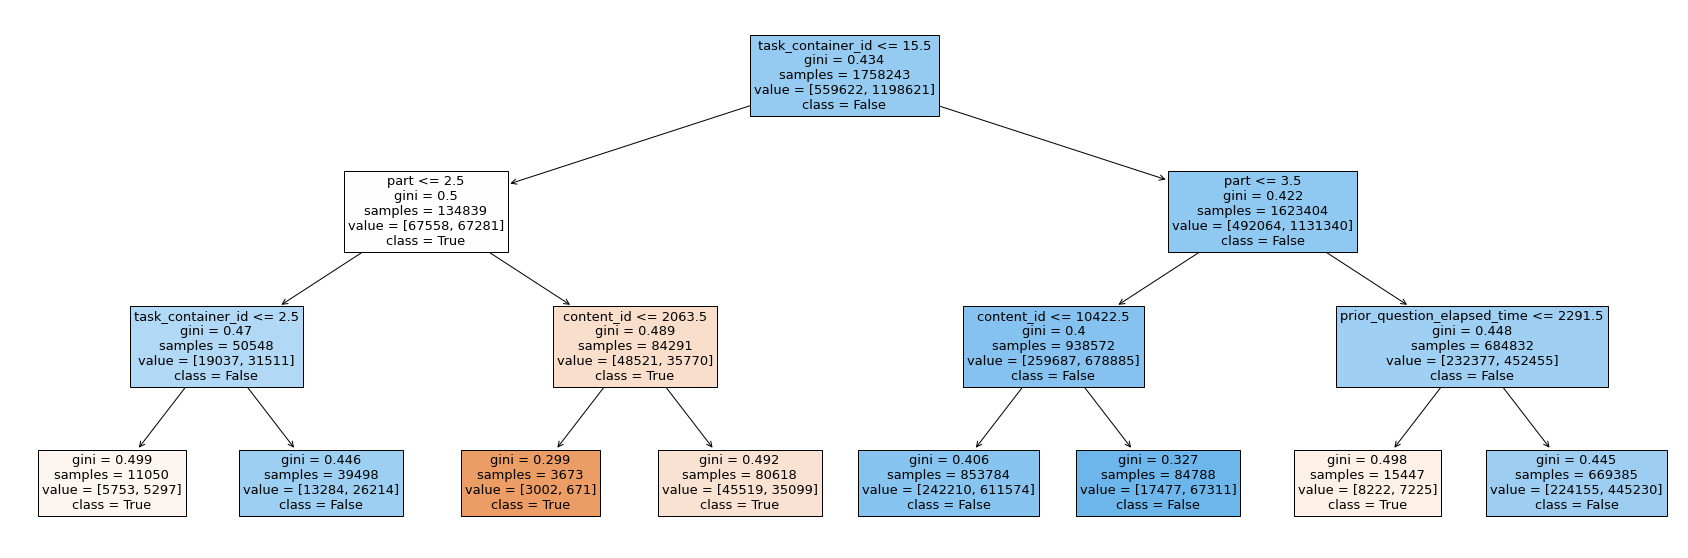

In [25]:
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(clf, feature_names=feature_columns,class_names=['True', 'False'],filled=True, fontsize=13)

In [26]:
y_pred = clf.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))

Accuracy: 0.691


## Attempt 1.2 - Different depths

test accuracy for different depths

In [27]:
def testing_depths(n):
    accuracies = []
    for i in range(1,n+2,10):
        clf = DecisionTreeClassifier(max_depth=i)
        clf = clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(metrics.accuracy_score(y_test, y_pred))
    return accuracies
accuracies = testing_depths(50)

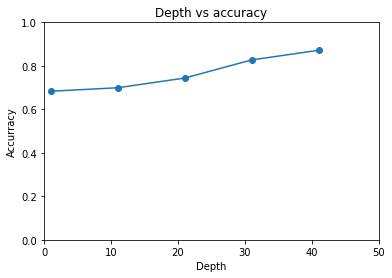

In [30]:
plt.plot(list(range(1,51,10)),accuracies, marker='o')
plt.ylim([0,1]);plt.xlim([0,50])
plt.xlabel('Depth');plt.ylabel('Accurracy');plt.title("Depth vs accuracy")
plt.show()

## Attempt 1.3 - default tree

with default tree

In [40]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))

Accuracy: 0.879


In [45]:
clf.get_depth()

67

## Attempt 2 - 5-fold cross validation

Used method: sklearn.model_selection.cross_val_score

In this method, 5-fold cross validation, so list of length 5 is an output.

In [11]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(max_depth=50)
scores = cross_val_score(estimator=clf,
                         X=df_whole_sample[feature_columns], 
                         y=df_whole_sample[target_column],
                         cv=None,  # use the default 5-fold cross validation
                         scoring='accuracy', # metrics.accuracy_score
                         n_jobs=4)

In [47]:
print("Achieved accuracy:")
print(numpy.round(scores,3))
print("Average accuracy: " + str(round(numpy.mean(scores),3)))

Achieved accuracy:
[0.564 0.604 0.611 0.606 0.545]
Average accuracy: 0.586


## Attempt 3 - ensemble

In this try sklearn.ensemble.RandomForestClassifier is used.

In short, it creates many trees, each created on different subset of whole dataset. When predicting, each tree makes it's own prediction and then the most common answer is returned (or average, depends on type of forest).

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20,  # number of trees 
                             oob_score=True, # use out-of-bag samples to estimate the generalization accuracy
                             n_jobs=4,
                             random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))

Accuracy: 0.861


In [35]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
df=pd.DataFrame(feature_importances)
_ = [print('Variable: {:33} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: timestamp                         Importance: 0.21
Variable: user_id                           Importance: 0.2
Variable: task_container_id                 Importance: 0.18
Variable: content_id                        Importance: 0.17
Variable: prior_question_elapsed_time       Importance: 0.14
Variable: tags                              Importance: 0.06
Variable: correct_answer                    Importance: 0.03
Variable: prior_question_had_explanation    Importance: 0.01
Variable: part                              Importance: 0.01
Variable: content_type_id                   Importance: 0.0


Importance equals 0? Value of 'content_type_id' is the same for every record and means 'question'. All records where the meaning was different (i.e. 'lecture') had Nan values in some other fields and were removed at the beginning.

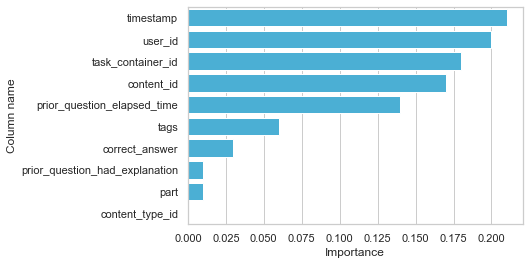

In [36]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.barplot(x=df[1],y=df[0], color='#34baeb')
plt.xlabel("Importance");plt.ylabel("Column name")
plt.show()

## Attempt 4.1 - xgboost

Just to see the results.

In [11]:
import xgboost as xgb

# change True to 1, False to 0
X_train_01 = X_train
X_test_01 = X_test
X_train_01.prior_question_had_explanation = X_train_01.prior_question_had_explanation.astype(int)
X_test_01.prior_question_had_explanation = X_test_01.prior_question_had_explanation.astype(int)



In [104]:
# model: gbtree
xg_tree = xgb.XGBClassifier(booster='gbtree',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True)

xg_tree.fit(X_train_01, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            eval_metric='logloss')

[0]	validation_0-logloss:0.65157	validation_1-logloss:0.65142
[1]	validation_0-logloss:0.63043	validation_1-logloss:0.63015
[2]	validation_0-logloss:0.61905	validation_1-logloss:0.61871
[3]	validation_0-logloss:0.61301	validation_1-logloss:0.61265
[4]	validation_0-logloss:0.60936	validation_1-logloss:0.60895
[5]	validation_0-logloss:0.60738	validation_1-logloss:0.60701
[6]	validation_0-logloss:0.60613	validation_1-logloss:0.60579
[7]	validation_0-logloss:0.60519	validation_1-logloss:0.60486
[8]	validation_0-logloss:0.60446	validation_1-logloss:0.60421
[9]	validation_0-logloss:0.60401	validation_1-logloss:0.60377
[10]	validation_0-logloss:0.60352	validation_1-logloss:0.60332
[11]	validation_0-logloss:0.60321	validation_1-logloss:0.60306
[12]	validation_0-logloss:0.60279	validation_1-logloss:0.60266
[13]	validation_0-logloss:0.60236	validation_1-logloss:0.60227
[14]	validation_0-logloss:0.60202	validation_1-logloss:0.60196
[15]	validation_0-logloss:0.60158	validation_1-logloss:0.60153
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='gpu_hist', validate_parameters=True, verbosity=None)

In [105]:
y_pred = xg_tree.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))

Accuracy: 0.701


In [116]:
# Load evals result by calling the evals_result() function
evals_result = xg_tree.evals_result()
print('logloss metric accessed directly from validation_0:')
print('first: ' + str(evals_result['validation_0']['logloss'][0]))
print('last: ' + str(evals_result['validation_0']['logloss'][-1]))
print("(the lower, the better)")



logloss metric accessed directly from validation_0:
first: 0.651571
last: 0.585934
(the lower, the better)


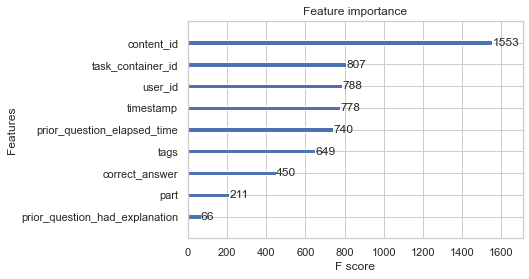

In [117]:
# How many times was this variable split on?
xgb.plot_importance(xg_tree, max_num_features=None)
plt.show()

## Attempt 4.2 - xgboost

Here a few parameters were checked with sklearn.model_selection.GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# model: gbtree
xg_tree_gbtree = xgb.XGBClassifier(booster='gbtree',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True)

parameters = {'max_depth': [4, 6, 8],
              'n_estimators': [20, 50, 100]}

clf = GridSearchCV(xg_tree_gbtree, parameters,verbose=1,n_jobs=1,cv=3)
clf.fit(X_train_01, y_train, verbose=True,eval_metric='logloss')


# Mean cross-validated score of the best_estimator
print(clf.best_score_)
# 0.7045505086612033

print(clf.best_params_)
# {'max_depth': 8, 'n_estimators': 100}

In [138]:
# model: dart
xg_tree_dart = xgb.XGBClassifier(booster='dart',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True)

parameters = {'max_depth': [6,8,10],
              'n_estimators': [20, 50, 100]}

clf = GridSearchCV(xg_tree_dart, parameters,verbose=1,n_jobs=1,cv=3)
clf.fit(X_train_01, y_train, verbose=True,eval_metric='logloss')


# Mean cross-validated score of the best_estimator
print(clf.best_score_) 
# 0.712765527859346

print(clf.best_params_)
# {'max_depth': 10, 'n_estimators': 100}

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 65.0min finished
0.712765527859346
{'max_depth': 10, 'n_estimators': 100}


I looks like along with increase of depth and number of estimators, mean cross validated score increases too. Let's check accuracy on test data with models with same parameters.

In [140]:
# model: gbtree
xg_tree_gbtree = xgb.XGBClassifier(booster='gbtree',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        n_estimators=100,
                        max_depth=8)

# model: dart
xg_tree_dart = xgb.XGBClassifier(booster='dart',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        n_estimators=100,
                        max_depth=8)

In [141]:
xg_tree_gbtree.fit(X_train, y_train, eval_metric='logloss', verbose=True)
y_pred_gbtree = xg_tree_gbtree.predict(X_test)
print("Accuracy gbtree:",round(metrics.accuracy_score(y_test, y_pred_gbtree),3))

Accuracy gbtree: 0.708


In [142]:
xg_tree_dart.fit(X_train, y_train, eval_metric='logloss', verbose=True)
y_pred_dart = xg_tree_dart.predict(X_test)
print("Accuracy dart:",round(metrics.accuracy_score(y_test, y_pred_dart),3))

Accuracy dart: 0.706


gbtree has similar accuracy to dart but is waay faster, so I'll stick to the default booster

Next, I'll compare grow_policy parameters: depthwise vs lossguide. depthwise is default, so below I'll run only lossguide.

In [157]:
# grow_policy='lossguide'
xg_tree_gbtree2 = xgb.XGBClassifier(booster='gbtree',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        n_estimators=50,
                        max_depth=8,
                        grow_policy='lossguide')
xg_tree_gbtree2.fit(X_train, y_train, eval_metric='logloss', verbose=True)
y_pred_gbtree2 = xg_tree_gbtree2.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred_gbtree2),3))

Accuracy: 0.703


### Conclusion of xgboost attempt 2

There are countless possible combinations of parameters but from experimenting with them above I learned a few things. 

1. First of all, 'dart' booster was terribly slow compared to 'gbtree' booster in the setting above. 
2. Accurracy is nearly the same.
3. Parameters in the attempt 4.1 turned out to be as good as here.
4. Some parameters such as grow_policy have not changed accuracy by any means.

## Attempt 4.3 - xgboost random forest

In [12]:
xg_forest = xgb.XGBRFClassifier(booster='gbtree',
                        n_jobs=2,
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        n_estimators=20)
xg_forest.fit(X_train, y_train, eval_metric='logloss', verbose=True)
y_pred_forest = xg_forest.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred_forest),3))

Accuracy: 0.694


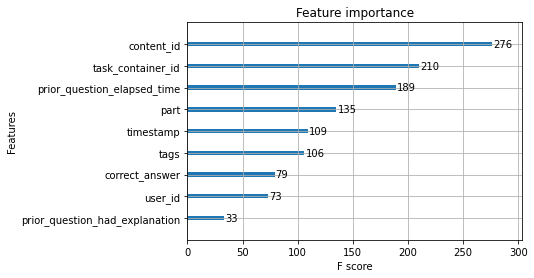

In [13]:
# How many times was this variable split on?
xgb.plot_importance(xg_forest, max_num_features=None)
plt.show()

### Let's visualize!

Max depth is decreased to 4.

Accuracy: 0.691


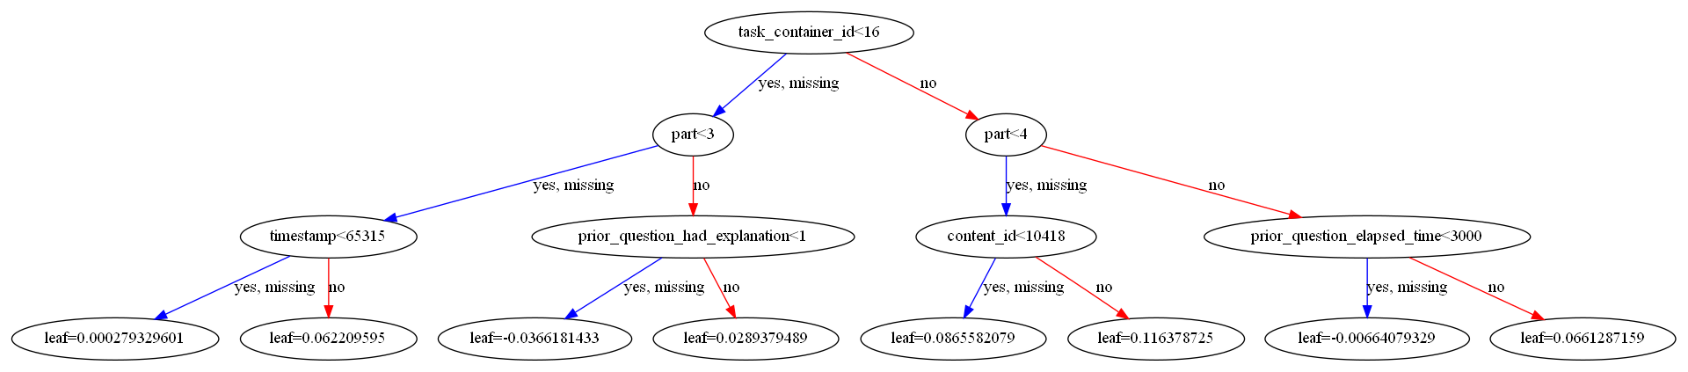

In [39]:
xg_forest = xgb.XGBRFClassifier(booster='gbtree',
                        n_jobs=2,
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        n_estimators=10,
                        max_depth=3) 
xg_forest.fit(X_train, y_train, eval_metric='logloss', verbose=True)
y_pred_forest = xg_forest.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred_forest),3))
xgb.plot_tree(xg_forest)
plt.rcParams['figure.figsize'] = [40, 10]
plt.show()

# Summary of what I got so far

1. Decision tree clasifier achieved >0.8 accuracy if has depth of more than 30.
2. 5-fold cross validation with the same decision tree clasifier on whole dataset gave suprisingly low accuracy of about 0.58 , why? (should I be surprised?) 
3. Random Forest Classifier got accuracy a bit lower than the simple decision tree clasifier. (0.861 vs 0.879)
3. xgboost, no matter which one, got me results of around 0.7 accuracy

## Last step

Add a new feature - depending on timestamp, if timestamp is around 24h \* n , for natural n, then the value will be 1, otherwise 0. 
I wonder if those spikes in usage would be helpful (and each spike is around 24 \* n hours after first answered question).

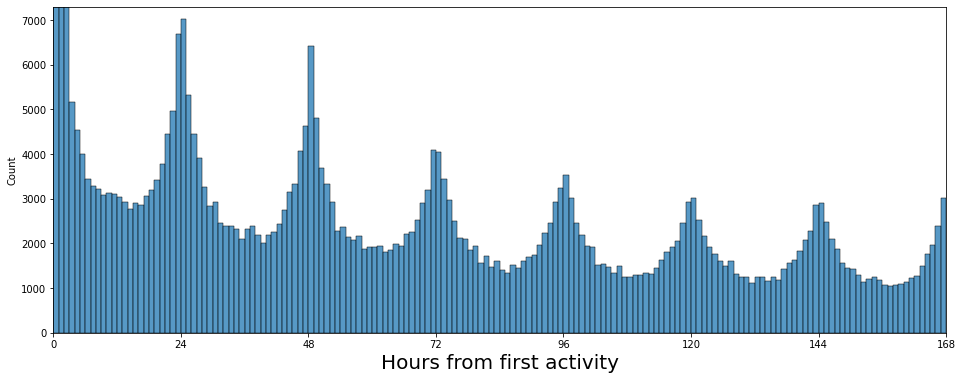

In [59]:
import seaborn as sns
tmp = df_whole_sample[(df_whole_sample.timestamp < 604800000)] 
tmp.timestamp = tmp.timestamp.div(1000*3600)
plt.figure(figsize=(16, 6))
h = sns.histplot(data=tmp,x='timestamp',bins=24*7)
h.set(ylim=(0,7300),xlim=(0,24*7),xticks=[i * 24 for i in range(0,8)]); h.set_xlabel("Hours from first activity",fontsize=20)
plt.show()


## Adding a new feature

As described above

In [16]:
df_more_features = df_whole_sample

In [17]:
def everyday_2h_span(x):
    hour = x/(1000*3600)
    if(hour < 1): # if answer was less than 60 minutes after first interaction - ignore
        return 0
    hourMod = hour % 24
    if((hourMod <= 0) or (hourMod >= 23)):
        return 1
    return 0

def everyday_4h_span(x):
    hour = x/(1000*3600)
    if(hour < 1): # if answer was less than 60 minutes after first interaction - ignore
        return 0
    hourMod = hour % 24
    if((hourMod <= 1) or (hourMod >= 22)):
        return 1
    return 0

df_more_features['everyday_2h_span'] = df_more_features.timestamp.apply(everyday_2h_span)
df_more_features['everyday_4h_span'] = df_more_features.timestamp.apply(everyday_4h_span)
sum2h = df_more_features['everyday_2h_span'].sum()
sum4h = df_more_features['everyday_4h_span'].sum()
print("Out of",len(df_more_features), 'there are', sum2h, '2h == 1 and', sum4h, '4h==1 records.')

Out of 2344325 there are 137131 2h == 1 and 397818 4h==1 records.


In [18]:
# Note that 'timestamp' column has been ommited to see if new features are helpful or rather not (answer: not helpful)
# Since 'timestamp' was important earlier, I'll check importance of 2 new features when the original is not available.

feature_columns = ['user_id' ,'content_id', 'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'correct_answer', 'part', 'tags','everyday_2h_span','everyday_4h_span']
# feature_columns = ['timestamp','user_id' ,'content_id', 'task_container_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'correct_answer', 'part', 'tags','everyday_2h_span','everyday_4h_span']
target_column = ['answered_correctly']

X = df_more_features[feature_columns]
y = df_more_features[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) 

### 1. Sklearn decision tree

Accuracy: 0.877


65

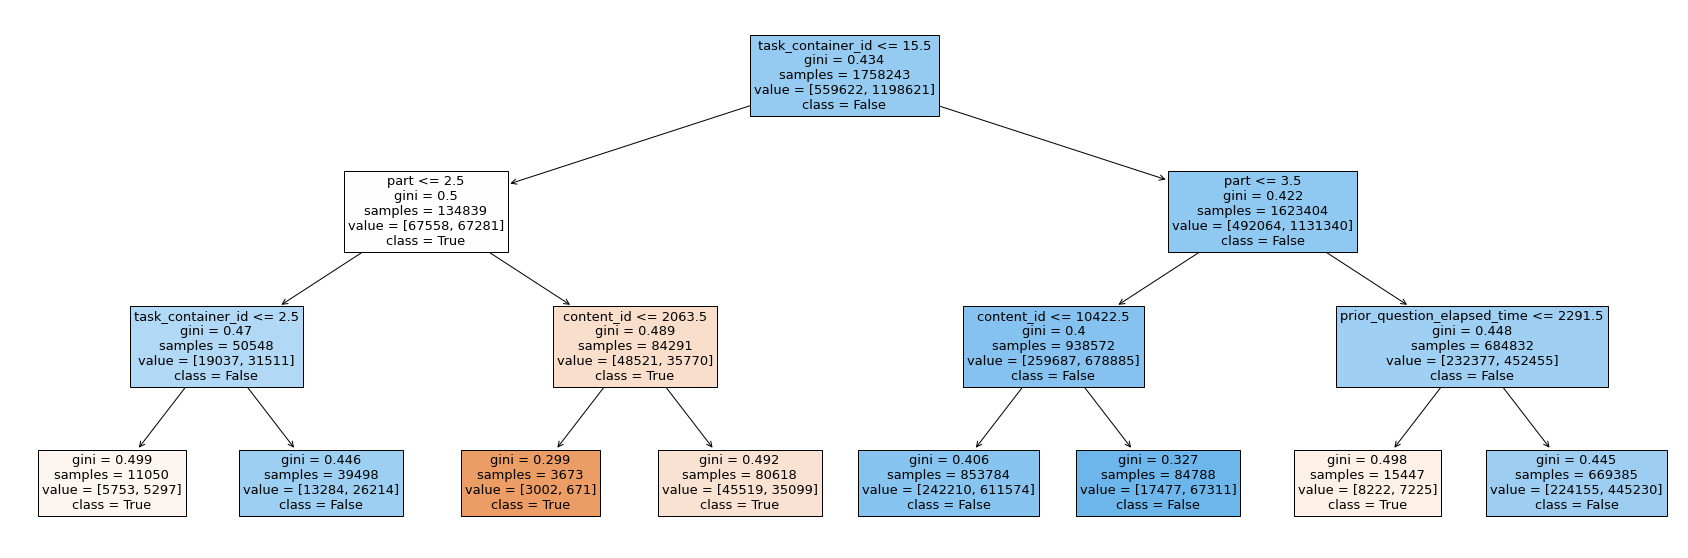

In [15]:
# graph
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train,y_train)
fig = plt.figure(figsize=(30,10))
_ = tree.plot_tree(clf, feature_names=feature_columns,class_names=['True', 'False'],filled=True, fontsize=13)

# default
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
clf.get_depth()

### 2. 5-fold validation

In [16]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()
scores = cross_val_score(estimator=clf,
                         X=df_more_features[feature_columns], 
                         y=df_more_features[target_column],
                         cv=None,  # use the default 5-fold cross validation
                         scoring='accuracy', # metrics.accuracy_score
                         n_jobs=4)
print("Achieved accuracy:")
print(numpy.round(scores,3))
print("Average accuracy: " + str(round(numpy.mean(scores),3)))

Achieved accuracy:
[0.567 0.604 0.609 0.61  0.548]
Average accuracy: 0.588


### 3. Sklearn ensemle

Accuracy: 0.824


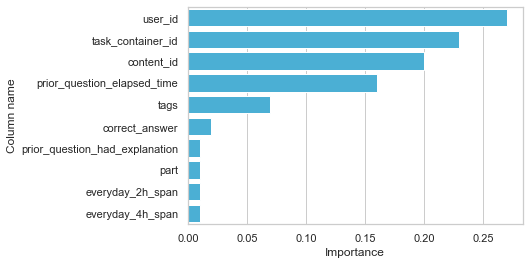

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=20,  # number of trees 
                             oob_score=True, # use out-of-bag samples to estimate the generalization accuracy
                             n_jobs=4,
                             random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))

# Get numerical feature importances
importances = list(rfc.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
df=pd.DataFrame(feature_importances)

import seaborn as sns
sns.set_theme(style="whitegrid")
sns.barplot(x=df[1],y=df[0], color='#34baeb')
plt.xlabel("Importance");plt.ylabel("Column name")
plt.show()

### 4. xgboost

Accuracy: 0.701


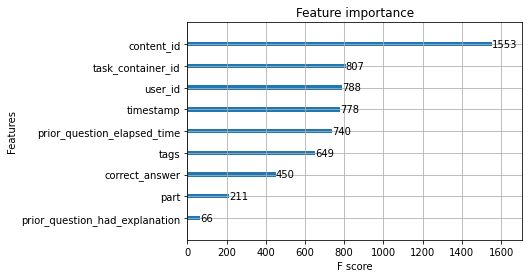

In [15]:
import xgboost as xgb

# change True to 1, False to 0
X_train_01 = X_train; X_test_01 = X_test
X_train_01.prior_question_had_explanation = X_train_01.prior_question_had_explanation.astype(int)
X_test_01.prior_question_had_explanation = X_test_01.prior_question_had_explanation.astype(int)

xg_tree = xgb.XGBClassifier(booster='gbtree',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        max_depth=6
)

xg_tree.fit(X_train_01, y_train, eval_metric='logloss')
y_pred = xg_tree.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
# How many times was this variable split on?
xgb.plot_importance(xg_tree, max_num_features=None)
plt.show()

## So... what happened?

From my understanding, new features were not correlated with answer correctness and the only effect is a bit lower accuracy score.

# After presentation updates

As mentioned during showing above results, xgboost should have much bigger max_depth parameter to achieve similar accuracy as default Decision Tree Clasifiers from sklearn (default got accuracy of 0.879 with depth 67, see Attempt 1.2). Therefore, below you can see accuracy of xgboost with depth greater than default 6.

## Check XGboost with bigger depth

and without new features

In [10]:
import xgboost as xgb

# change True to 1, False to 0
X_train_01 = X_train; X_test_01 = X_test
X_train_01.prior_question_had_explanation = X_train_01.prior_question_had_explanation.astype(int)
X_test_01.prior_question_had_explanation = X_test_01.prior_question_had_explanation.astype(int)


def XGboost_acc_for_depth(maxdeppth):
    xg_tree = xgb.XGBClassifier(booster='gbtree',
                            n_jobs=2,
                            learning_rate=0.3, # used to prevent overfitting 
                            subsample=0.7, # randomly choose 0.7 examples for training
                            tree_method='gpu_hist', 
                            random_state=42,
                            validate_parameters=True,
                            max_depth=maxdeppth)

    xg_tree.fit(X_train_01, y_train, eval_metric='logloss')
    y_pred = xg_tree.predict(X_test)
    return round(metrics.accuracy_score(y_test, y_pred),3)

In [11]:
print("Accuracy for depth 5 is:",XGboost_acc_for_depth(5))

Accuracy for depth 5 is: 0.699


In [12]:
print("Accuracy for depth 10 is:",XGboost_acc_for_depth(10))

Accuracy for depth 10 is: 0.72


In [13]:
print("Accuracy for depth 15 is:",XGboost_acc_for_depth(15))

Accuracy for depth 15 is: 0.789


Accuracy: 0.789


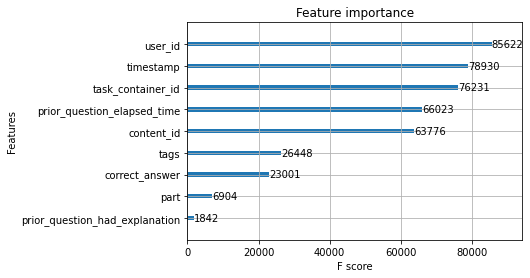

In [14]:
import xgboost as xgb

maxdeppth = 15

xg_tree = xgb.XGBClassifier(booster='gbtree',
                        n_jobs=2,
                        learning_rate=0.3, # used to prevent overfitting 
                        subsample=0.7, # randomly choose 0.7 examples for training
                        tree_method='gpu_hist', 
                        random_state=42,
                        validate_parameters=True,
                        max_depth=maxdeppth)

xg_tree.fit(X_train_01, y_train, eval_metric='logloss')
y_pred = xg_tree.predict(X_test)
print("Accuracy:",round(metrics.accuracy_score(y_test, y_pred),3))
# How many times was this variable split on?
xgb.plot_importance(xg_tree, max_num_features=None)
plt.show()

## Summary

To sum up, simple trees from sklearn are quite good, while xgboost requires more computing power, but maybe would give better results if tuned properly. 

For further exercise you may test lbgm, come up with new features or use *lectures.csv* (not used anywhere above).